# Food Classifier

### In this project we will be using CNN models to predict the food in images.

This notebook was run in Google Colab and is best run using GPUs as the data augmentation section takes quite some time to run.

## Importing libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from numpy.random import seed

seed(1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D,
                                     SeparableConv2D, ReLU, MaxPooling2D, Add, Input,
                                     BatchNormalization, MaxPool2D, GlobalAvgPool2D,
                                     RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception, decode_predictions, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims


from PIL import Image
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import requests
import datetime
import os

In [2]:
# printing GPU info to make sure the GPU is being utilized
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 23 08:54:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# printing available RAM to make sure it's enough
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Reading in the data

In [4]:
# loading in Google Drive to retrieve the dataset(s)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# creating a path variable for the data subset we'll be modeling on
subset_dessert = "/content/drive/My Drive/Capstone/food-11/images/dessert"
img_size = 299
img_size_tup = (299, 299)

# loading the images from the path into a train_data variable while resizing the images and splitting the data
# color mode will be 'rgb' which is 3 colors
# labels are 'categorical' since there are more than 2 categories
train_data = tf.keras.preprocessing.image_dataset_from_directory(
          subset_dessert, 
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='training',
          # interpolation='bilinear',
          # follow_links=False,
          # crop_to_aspect_ratio=True
)

Found 20000 files belonging to 20 classes.
Using 16000 files for training.


In [6]:
# loading the images for validation from the above split into a test_data variable while resizing same as above 

test_data = tf.keras.preprocessing.image_dataset_from_directory(
          subset_dessert,
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='validation',
          # interpolation='bilinear',
          # follow_links=False,
          # crop_to_aspect_ratio=True
)

Found 20000 files belonging to 20 classes.
Using 4000 files for validation.


In [7]:
# looking at our train_data variable to see shape and type
train_data

<BatchDataset shapes: ((None, 299, 299, 3), (None, 20)), types: (tf.float32, tf.float32)>

In [8]:
# creating variable for class names
class_names = test_data.class_names

# creating variable for number of classes
n_classes = len(train_data.class_names)
n_classes, class_names

(20,
 ['apple_pie',
  'baklava',
  'beignets',
  'bread_pudding',
  'cannoli',
  'carrot_cake',
  'cheesecake',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'creme_brulee',
  'cup_cakes',
  'donuts',
  'frozen_yogurt',
  'ice_cream',
  'macarons',
  'panna_cotta',
  'red_velvet_cake',
  'strawberry_shortcake',
  'tiramisu'])

# EDA & Preprocessing the Data

In [9]:
# function for preprocessing our data into X, y as numpy arrays that are rescaled between 0-1
def preprocess_img_input(batch_dataset):
    for images, labels in batch_dataset.take(1):  # only take first element of dataset
        X = images.numpy()
        y = labels.numpy()

        X /= 255

        return X, y

# splitting our images and labels into X_train and y_train
# converting them to numpy arrays in order to be able to resize them
X_train, y_train = preprocess_img_input(train_data)
X_test, y_test = preprocess_img_input(test_data)
# checking our x and y
X_train[0][0][0], y_train[0]

(array([0.97570336, 0.9675519 , 0.9381712 ], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.], dtype=float32))

In [10]:
# checking the shape of X_train and y_train
X_train.shape, y_train.shape

((32, 299, 299, 3), (32, 20))

In [11]:
# creating our input variable for our model from the shape of our first X_train set of values
input_shape = X_train[0].shape

# Visualizing the Data

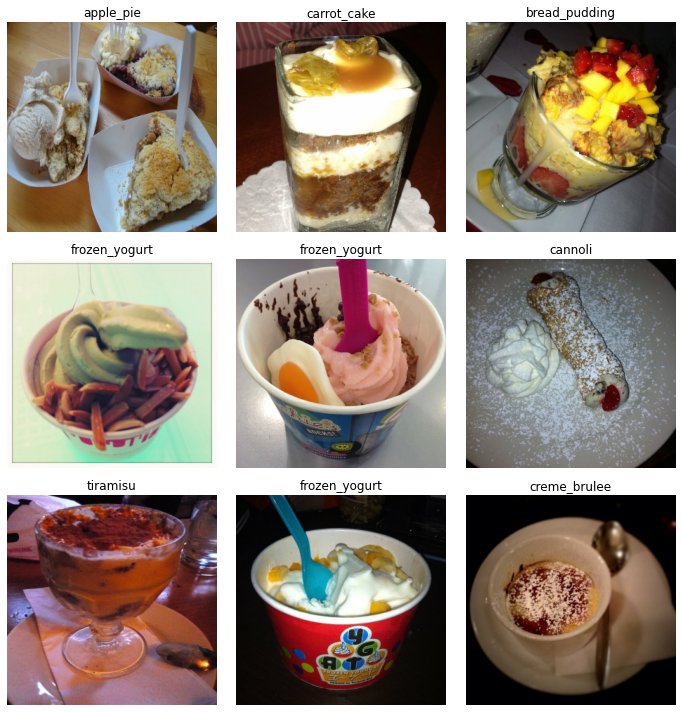

In [12]:
# code help from https://www.tensorflow.org/tutorials/images/classification
# visualing images from our dataset with their labels
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i], axis=0)])
        plt.axis("off")
        plt.tight_layout()

# Predicting on our Data Using Pre-Trained Model

49152/35363 [=========================================] - 0s 0us/step


[('n07880968', 'burrito', 0.8210398),
 ('n07579787', 'plate', 0.026826724),
 ('n07697537', 'hotdog', 0.026526093),
 ('n07614500', 'ice_cream', 0.0061624246),
 ('n07836838', 'chocolate_sauce', 0.005535442)]

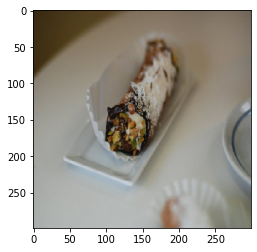

In [13]:
# code from https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras

# visualizing one image with predictions from Xception
# instantiating the Xception pre-trained weights model
model = Xception(weights='imagenet')
# our image path to one of our dataset's images
img_path = "/content/drive/My Drive/Capstone/food-11/images/dessert/cannoli/3621.jpg"
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
plt.imshow(img)
# decoding the results into a list of tuples (class, description, probability)
decode_predictions(preds, top=5)[0]

Our pre-trained model Xception (which was also trained on food images as well as other classes) is doing a pretty terrible job predicting our cannoli, but to be fair it does look a lot like a burrito. This pre-trained model will serve as the base for our model to try to get our predictions right.

# Modeling with Neural Nets & Pre-trained Weights

## Modeling with Xception Pretrained Model

In [14]:
# code from https://keras.io/api/optimizers/
# creating a learning rate schedule to use with our optimizer in our model
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.9,
    decay_steps=10000,
    decay_rate=0.9)

In [15]:
# code help: https://keras.io/api/applications/
# code help: https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

# instantiating the base pre-trained model
X_model = Xception(weights='imagenet', include_top=False)

# freezing the layers
for layer in X_model.layers:
    layer.trainable = False

# adding a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# adding a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=X_model.input, outputs=predictions)

# compiling the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
early_stop = EarlyStopping(mode='auto', patience=15)

# fitting and running the model
X_results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=32, callbacks=early_stop, workers=4)



83697664/83683744 [==============================] - 4s 0us/step
Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 3.0458 - accuracy: 0.0000e+00 - val_loss: 3.8679 - val_accuracy: 0.0625
Epoch 2/300
1/1 [==============================] - 0s 291ms/step - loss: 1.9072 - accuracy: 0.5000 - val_loss: 3.8402 - val_accuracy: 0.0938
Epoch 3/300
1/1 [==============================] - 0s 294ms/step - loss: 2.8348 - accuracy: 0.4375 - val_loss: 5.7397 - val_accuracy: 0.0625
Epoch 4/300
1/1 [==============================] - 0s 296ms/step - loss: 3.2621 - accuracy: 0.4688 - val_loss: 4.5803 - val_accuracy: 0.0625
Epoch 5/300
1/1 [==============================] - 0s 288ms/step - loss: 3.6008 - accuracy: 0.3750 - val_loss: 3.6219 - val_accuracy: 0.0625
Epoch 6/300
1/1 [==============================] - 0s 297ms/step - loss: 2.5481 - accuracy: 0.5625 - val_loss: 3.0317 - val_accuracy: 0.1250
Epoch 7/300
1/1 [==============================] - 0s 287ms/step - loss: 1.7210 - accura

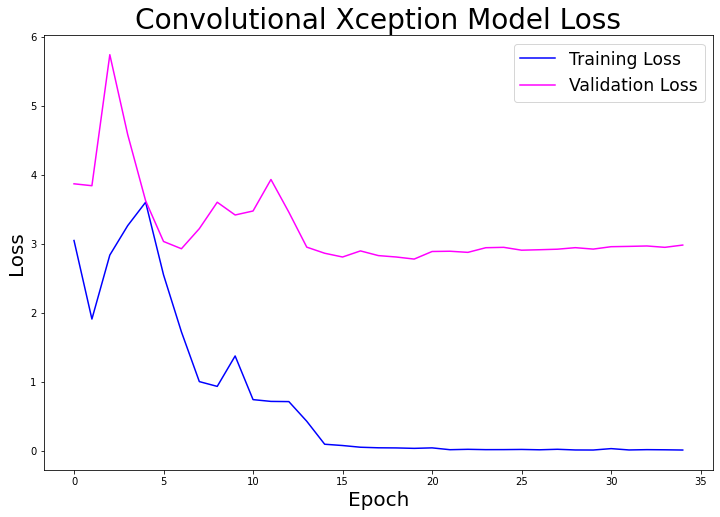

In [16]:
# plotting our loss for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['loss'], label='Training Loss', color='blue')
plt.plot(X_results.history['val_loss'], label='Validation Loss', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_loss_dessert_1.png', bbox_inches='tight');

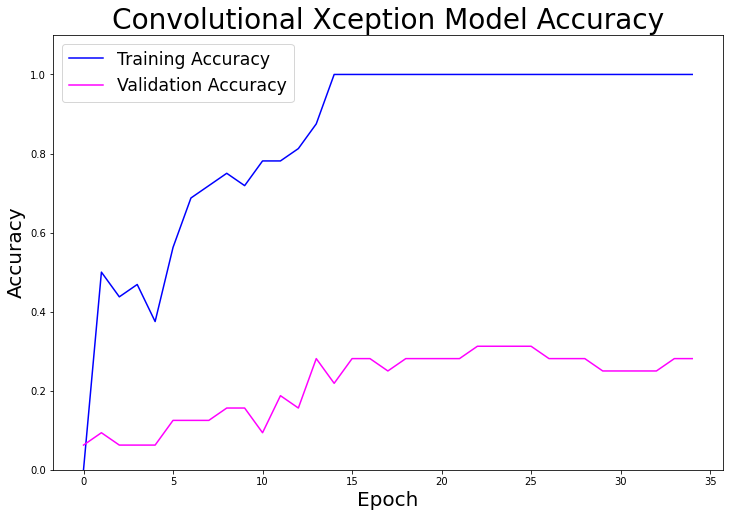

In [17]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(X_results.history['val_accuracy'], label='Validation Accuracy', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
plt.ylim(0, 1.10)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_dessert_1.png', bbox_inches='tight');

In [18]:
# evaluating on test data
X_score = model.evaluate(X_test, y_test, verbose=1)

X_labels = model.metrics_names

# printing Xception scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')

1/1 [==============================] - 0s 156ms/step - loss: 2.9797 - accuracy: 0.2812
Xception loss  : 2.9797325134277344
Xception accuracy   : 0.28125


** Interpretation **
The Xception pre=trained model is doing pretty well on this subset, with 81% accuracy on testing data (100% on training).

In [19]:
# saving the model
from tensorflow.keras.models import load_model, clone_model
model.save("/content/drive/My Drive/Capstone/Xception_model_dessert.h5")
pickle.dump(model, open("/content/drive/My Drive/Capstone/Xception_model_dessrts.p", 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://f61513c2-817b-4f3d-bf8c-b135992f5969/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [20]:
## code from lesson 9.04
# making predictions on X_test
preds_1 = np.argmax(model.predict(X_test), axis = 1)

# saving predictions to dataframe & output to .csv
X_test_pred_df_1 = pd.DataFrame({
    'Label': preds_1,
    'ImageId': range(1,X_test.shape[0] + 1)
})
X_test_pred_df_1.to_csv('/content/drive/My Drive/Capstone/X_preds_dessert.csv', index=False)

# Testing Our Model on Random Images

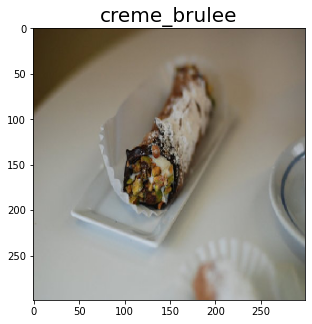

In [21]:
# visualizing one prediction
plt.figure(figsize=(5,5))
# our image path to one of our dataset's images
img_path = "/content/drive/My Drive/Capstone/food-11/images/dessert/cannoli/3621.jpg"
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);


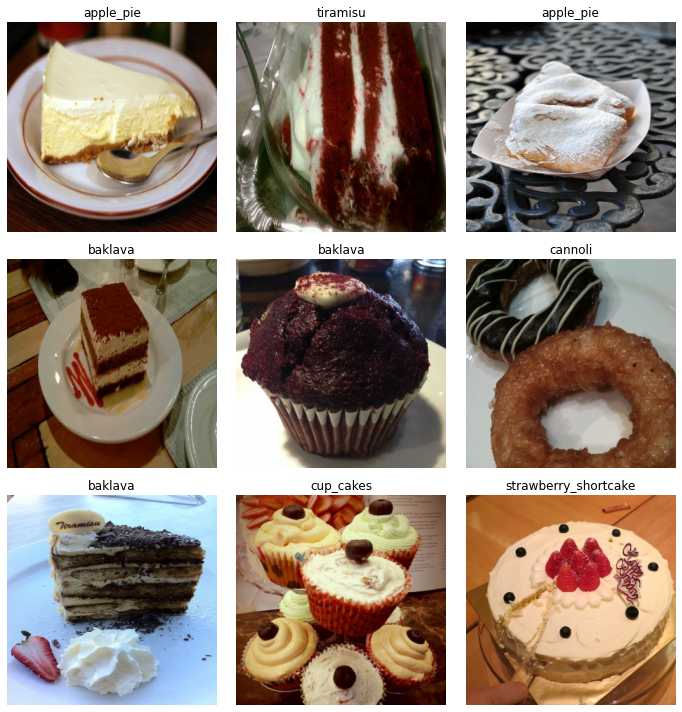

In [22]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # plt.imshow(X_test[i])
  result=(model.predict(X_test))
  plt.imshow(X_test[i])
  plt.title(class_names[np.argmax(result[i])])
  plt.axis("off")
  plt.tight_layout()
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_dessert_preds1.png', bbox_inches='tight');

Our Xception model is extremely overfit and doesn't perform well on our test data. Below we will try using data augmentation to add more images for training and testing, which should help our model's loss and scores. Data augmentation is a method of creating new similar images from our existing image dataset in order to supplement our data when there isn't enough to get good model results from.

In [23]:
# https://github.com/hbhasin/Image-Recognition-with-Deep-Learning/blob/master/Image%20Classification%20with%20Transfer%20Learning.md
# preprocessing our data using data augmentation

# data pre-processing for training
train_datagen =  ImageDataGenerator( 
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 0.25,
    zoom_range = 0.25,
    brightness_range=[0.6,1.0],
    fill_mode = 'nearest',
    horizontal_flip = True,
    validation_split=0.2)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 0.25,
    zoom_range = 0.25,
    brightness_range=[0.6,1.0],
    fill_mode = 'nearest',
    horizontal_flip = True,
    validation_split=0.2)


# generate and store training data
train_generator = train_datagen.flow_from_directory(
    subset_dessert,
    class_mode = 'categorical',
    target_size = img_size_tup,
    batch_size = 32, 
    subset='training',
    )

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    subset_dessert,
    class_mode = 'categorical',
    target_size = img_size_tup,
    batch_size = 32,
    subset='validation')

Found 16000 images belonging to 20 classes.
Found 4000 images belonging to 20 classes.


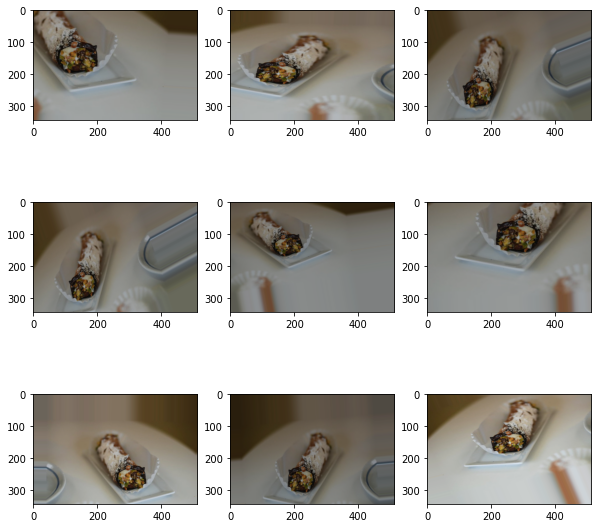

In [24]:
# code help from https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# visualizing one of our images with data augmentation implemented
plt.figure(figsize=(10, 10))
# load the image
img = load_img(img_path)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

data_augmentation = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = data_augmentation.next()
	# plot raw pixel data
	plt.imshow(batch[0])
# show the figure
plt.show()

In [25]:
# rerunning our model with data augmentation

# creating learning rate schedule to be used withour optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7, 
    decay_steps=10000,
    decay_rate=0.7)

# create the base pre-trained model
X_model = Xception(weights='imagenet', include_top=False)


# add a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)
# this is the model we train
model = Model(inputs=X_model.input, outputs=predictions)
# freezing the layers
for layer in X_model.layers:
    layer.trainable = False
# compiling the model
model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
# adding early stop
early_stop = EarlyStopping(mode='auto', patience=12)

# fitting the model, logging the results and the training time
now = datetime.datetime.now
t = now()
results_2 = model.fit(
    train_generator,
    epochs=100, 
    steps_per_epoch=112, 
    callbacks=early_stop, 
    workers=8,
    validation_data = validate_generator)
print('Training time: %s' % (now() - t))


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


112/112 [==============================] - 528s 5s/step - loss: 2.7313 - accuracy: 0.2215 - val_loss: 2.2172 - val_accuracy: 0.3528
Epoch 2/100
112/112 [==============================] - 234s 2s/step - loss: 2.4289 - accuracy: 0.2913 - val_loss: 2.1735 - val_accuracy: 0.3325
Epoch 3/100
112/112 [==============================] - 195s 2s/step - loss: 2.2625 - accuracy: 0.3415 - val_loss: 1.8551 - val_accuracy: 0.4425
Epoch 4/100
112/112 [==============================] - 163s 1s/step - loss: 2.1496 - accuracy: 0.3814 - val_loss: 1.8242 - val_accuracy: 0.4363
Epoch 5/100
112/112 [==============================] - 141s 1s/step - loss: 2.1430 - accuracy: 0.3839 - val_loss: 1.8352 - val_accuracy: 0.4555
Epoch 6/100
112/112 [==============================] - 128s 1s/step - loss: 2.0643 - accuracy: 0.4032 - val_loss: 1.7470 - val_accuracy: 0.4593
Epoch 7/100
112/112 [==============================] - 114s 987ms/step - loss: 2.0288 - accuracy: 0.4004 - val_loss: 1.6317 - val_accuracy: 0.4958
E

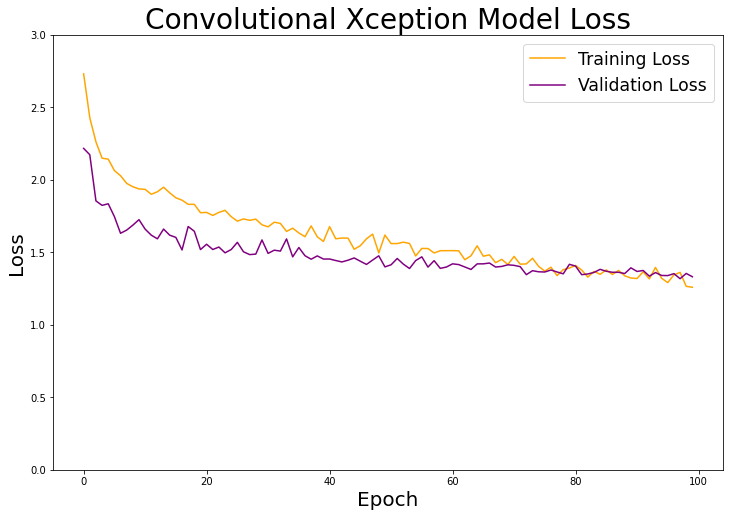

In [26]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(results_2.history['loss'], label='Training Loss', color='orange')
plt.plot(results_2.history['val_loss'], label='Validation Loss', color='purple')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.ylim(0, 3.0)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_loss_dessert.png', bbox_inches='tight');

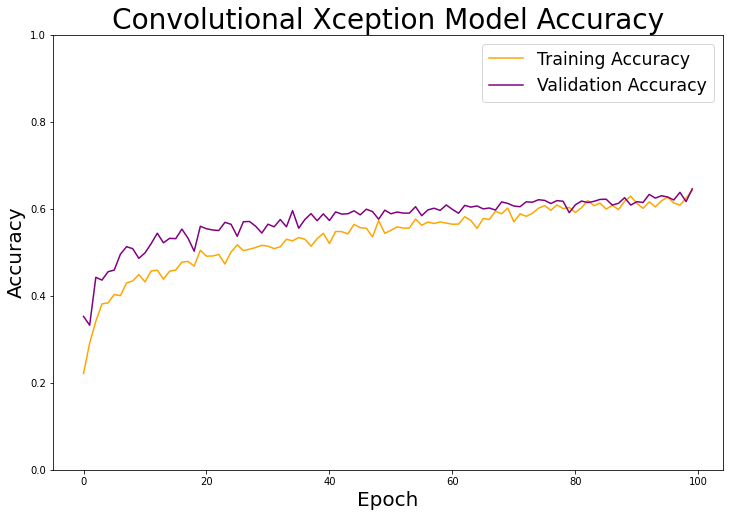

In [27]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(results_2.history['accuracy'], label='Training Accuracy', color='orange')
plt.plot(results_2.history['val_accuracy'], label='Validation Accuracy', color='purple')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
plt.ylim(0, 1.00)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_dessert.png', bbox_inches='tight');

In [28]:
model.save("/content/drive/My Drive/Capstone/Xception_model_dessert_DA.h5")
pickle.dump(model, open("/content/drive/My Drive/Capstone/Xception_model_desserts_DA.p", 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://825fad2d-f280-41f0-98e4-0efcfa4b02ec/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [29]:
# evaluating on test data
X_score_DA = model.evaluate(validate_generator, verbose=1)

X_labels_DA = model.metrics_names

# printing Xception scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')
print(f'Xception_DA {X_labels_DA[0]}  : {X_score_DA[0]}')
print(f'Xception_DA {X_labels_DA[1]}   : {X_score_DA[1]}')

125/125 [==============================] - 97s 775ms/step - loss: 1.3749 - accuracy: 0.6302
Xception loss  : 2.9797325134277344
Xception accuracy   : 0.28125
Xception_DA loss  : 1.374937653541565
Xception_DA accuracy   : 0.6302499771118164


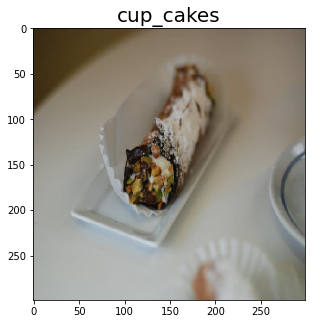

In [30]:
# visualizing one prediction
plt.figure(figsize=(5,5))
# our image path to one of our dataset's images
img_path = "/content/drive/My Drive/Capstone/food-11/images/dessert/cannoli/3621.jpg"
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);

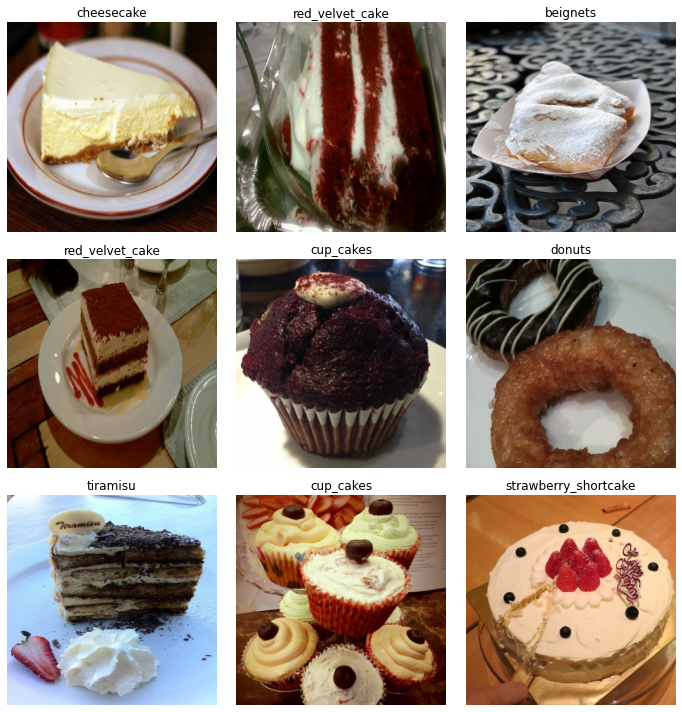

In [31]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # plt.imshow(X_test[i])
  result=(model.predict(X_test))
  plt.imshow(X_test[i])
  plt.title(class_names[np.argmax(result[i])])
  plt.axis("off")
  plt.tight_layout()
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_dessert_preds2.png', bbox_inches='tight');

# Conclusions & Recommendations

After running numerous different CNN models with different hyperparameters and different amounts of images and classes, we've learned the following:



1.   Preprocessing:

*   Image data should be preprocessed before modeling
*   Images should be resized to each be the same size and shape 
*   Turning the images into numpy arrays and normalizing the data points to be between 0-1 minimizes the data sizes going into the models which speeds up the model runtime without losing preformance.
*   Data augmentation greatly boosts the model performance, since it adds many more images for the model to train on.


2.   Models

*   Using a model with pre-trained weights such as Xception helps boost model performance without as much time trying many different layers with a custom model.
*   Hyperparameters should match the type of data and number of classes being predicted. We used the 'softmax' activator in our final layer which works best for predicting more than 2 classes, and we used SGD for our optimizer which we found gave us the best and most reliable model performance.
*   Using an optimizer with a scheduled learning rate helps boost performance as the learning rate is minimized exponentially over the steps of the model.
*   The more classes there are to predict, the more difficult it will be for the model to perform well since the data is basically diluted. The more classes there are, the more images you will need in each class to make up for the dilution.

## Conclusions

Our initial model with just 2 classes was fairly quickly able to get 100% accuracy on both training and testing using a fairly simple CNN. After changing our data to a dataset with 3 classes, we were able to get up to 96% accuracy using an Xception CNN model. At 4 classes, we dropped to about 81% accuracy using the same model. When we tried to use the same model on a dataset of 20 classes, we found the model performed exponentially worse and very overfit with 100% training accuracy but an abismal 21% validation accuracy.

After some research, we added data augmentation and reran the Xception model with much better success. Our model was no longer overfit, but only achieved up to 64% accuracy for the validation data.


## Future Recommendations

Running each model with data augmentation (and larger datasets in general) takes 1-2 hours, even when running on GPUs which is to say that this project in it's entirety will be time-consuming. In order to achieve a better model performance, more time needs to be taken to find more ways to improve upon our current models or try different models such as PyTorch. Some things that can be done to improve upon the model are adding more image data from other food image datasets to supplement our existing data, trying different preprocessing methods, stacking models, or possibly even building a model from scratch which would require more time to test run and rerun.

This project could serve as a basis for other projects such as:


*   Classifying food portion sizes
*   Predicting food calories or nutrional value based on food in image + food portions
*   Food segmentation, such as food quality segmentation for industrial food separating and packaging
*   AI for food service industry such as food service robots or food prep robots



